<a href="https://colab.research.google.com/github/PercyMayaba/Retail-Price-Optimization-using-Deep-Reinforcement-Learning/blob/main/RetailPriceOptimizationDRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install torch gymnasium kagglehub pandas matplotlib seaborn numpy scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import gymnasium as gym
from gymnasium import spaces
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [ ]:
import kagglehub
import os
import glob

# Download latest version
path = kagglehub.dataset_download("suddharshan/retail-price-optimization")
print("Path to dataset files:", path)

# Find the CSV file in the downloaded directory
# Use glob to search for any .csv file within the 'path' and its subdirectories
csv_files = glob.glob(os.path.join(path, '**', '*.csv'), recursive=True)

if csv_files:
    dataset_path = csv_files[0] # Take the first CSV file found
    print(f"Found CSV file: {dataset_path}")
    df = pd.read_csv(dataset_path)

    print("Dataset shape:", df.shape)
    print("\nDataset columns:")
    print(df.columns.tolist())
    print("\nFirst few rows:")
    df.head()
else:
    print("No CSV files found in the downloaded dataset.")

Path to dataset files: /root/.cache/kagglehub/datasets/suddharshan/retail-price-optimization/versions/2
Found CSV file: /root/.cache/kagglehub/datasets/suddharshan/retail-price-optimization/versions/2/retail_price.csv
Dataset shape: (676, 30)

Dataset columns:
['product_id', 'product_category_name', 'month_year', 'qty', 'total_price', 'freight_price', 'unit_price', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month', 'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2', 'comp_3', 'ps3', 'fp3', 'lag_price']

First few rows:


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday              

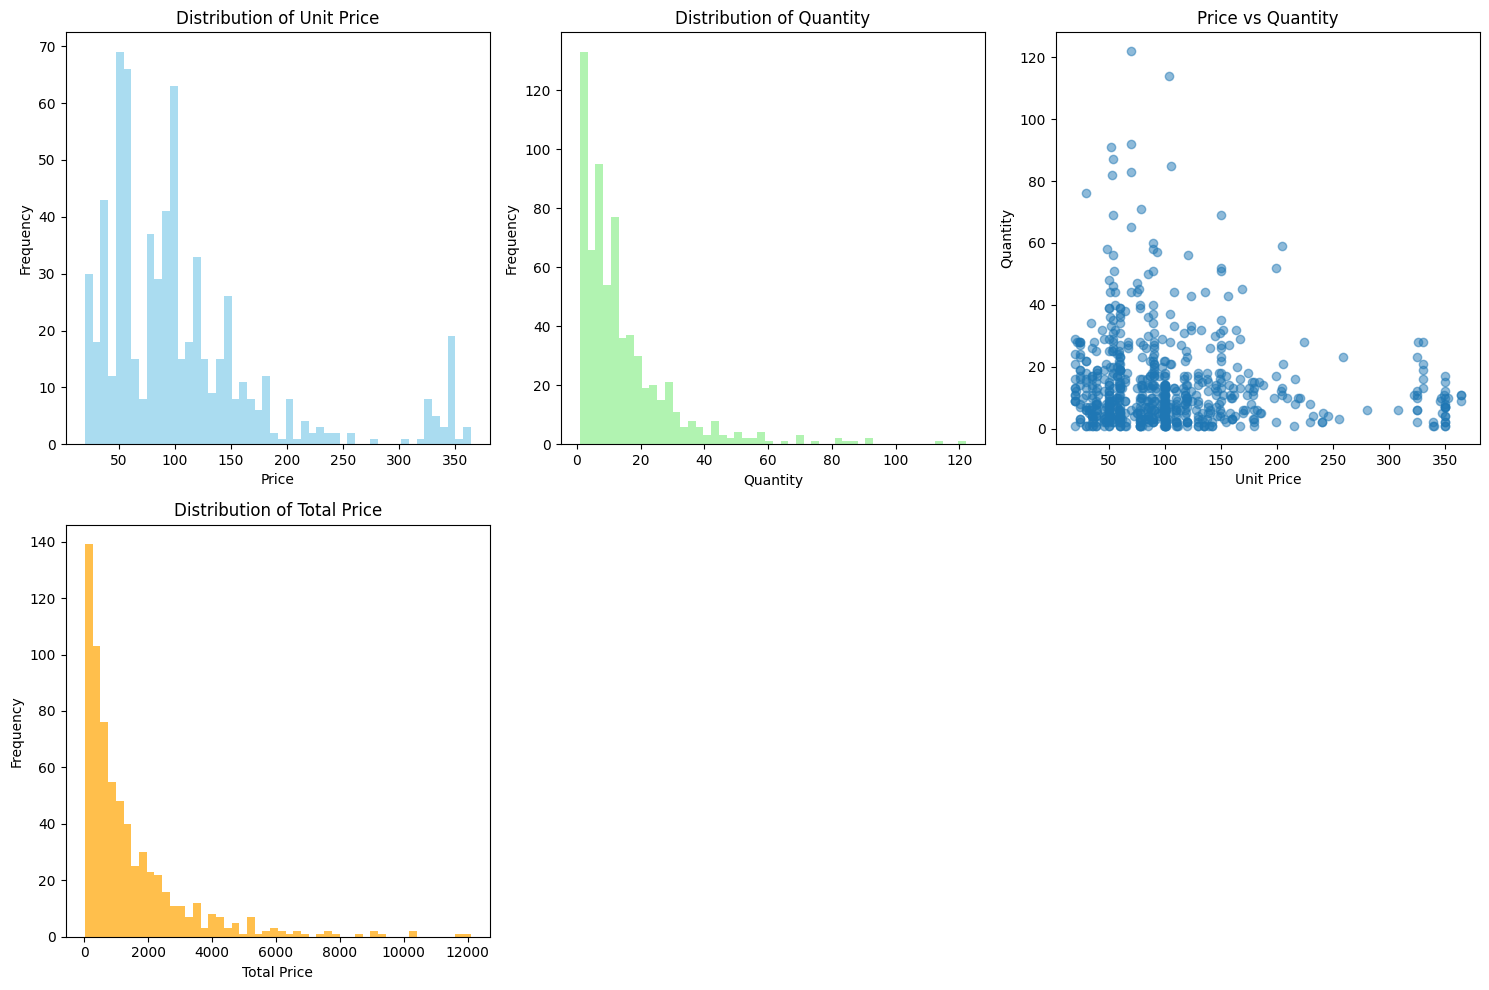

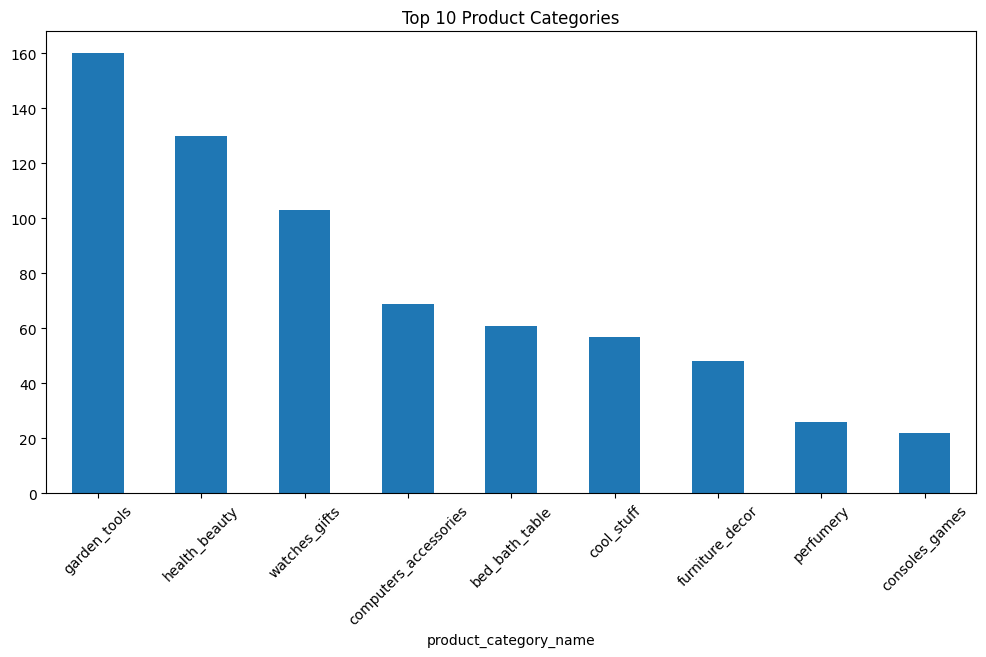

In [ ]:
# Basic statistics
print("Dataset Info:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Visualize key numerical features
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df['unit_price'], bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution of Unit Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
plt.hist(df['qty'], bins=50, alpha=0.7, color='lightgreen')
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
plt.scatter(df['unit_price'], df['qty'], alpha=0.5)
plt.title('Price vs Quantity')
plt.xlabel('Unit Price')
plt.ylabel('Quantity')

plt.subplot(2, 3, 4)
df['total_price'] = df['unit_price'] * df['qty']
plt.hist(df['total_price'], bins=50, alpha=0.7, color='orange')
plt.title('Distribution of Total Price')
plt.xlabel('Total Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Analyze product categories
if 'product_category_name' in df.columns:
    plt.figure(figsize=(12, 6))
    df['product_category_name'].value_counts().head(10).plot(kind='bar')
    plt.title('Top 10 Product Categories')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
class RetailPricingEnv(gym.Env):
    def __init__(self, df, initial_inventory=100, max_steps=30):
        super(RetailPricingEnv, self).__init__()

        self.df = df
        self.initial_inventory = initial_inventory
        self.max_steps = max_steps
        self.current_step = 0

        # Define action space (prices normalized between 0 and 1, will be scaled)
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)

        # Define state space: [inventory_level, day_of_week, month, current_price, demand_trend]
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0, -1]),
            high=np.array([initial_inventory, 6, 12, 1, 1]),
            dtype=np.float32
        )

        # Price bounds based on dataset
        self.min_price = df['unit_price'].min()
        self.max_price = df['unit_price'].max()

        # Reset environment
        self.reset()

    def _get_demand_function(self, price):
        """Simulate demand based on price elasticity"""
        base_demand = 10
        price_elasticity = -2.0  # Typical elasticity for retail
        demand = base_demand * (price / self.base_price) ** price_elasticity
        return max(0, int(demand + np.random.normal(0, 1)))

    def _get_competitor_price(self):
        """Simulate competitor pricing"""
        return np.random.uniform(self.min_price * 0.8, self.max_price * 1.2)

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.inventory = self.initial_inventory
        self.base_price = np.random.uniform(self.min_price, self.max_price)
        self.current_price = self.base_price

        # Initial state
        self.state = np.array([
            self.inventory / self.initial_inventory,  # Normalized inventory
            np.random.randint(0, 7),  # Day of week
            np.random.randint(1, 13),  # Month
            (self.current_price - self.min_price) / (self.max_price - self.min_price),  # Normalized price
            0.0  # Demand trend (initial)
        ], dtype=np.float32)

        return self.state, {}

    def step(self, action):
        # Convert action to actual price
        new_price = self.min_price + action[0] * (self.max_price - self.min_price)
        self.current_price = new_price

        # Calculate demand
        demand = self._get_demand_function(new_price)
        competitor_price = self._get_competitor_price()

        # Adjust demand based on competition
        price_ratio = competitor_price / new_price
        if price_ratio < 0.9:  # Competitor is cheaper
            demand *= 0.7
        elif price_ratio > 1.1:  # Our price is cheaper
            demand *= 1.3

        # Ensure demand doesn't exceed inventory
        actual_sales = min(demand, self.inventory)
        self.inventory -= actual_sales

        # Calculate reward (profit)
        cost_price = new_price * 0.6  # Assume 40% margin at base price
        reward = actual_sales * (new_price - cost_price)

        # Inventory holding cost
        holding_cost = self.inventory * cost_price * 0.01
        reward -= holding_cost

        # Update state
        self.state = np.array([
            self.inventory / self.initial_inventory,
            (self.current_step % 7),  # Day of week
            (self.current_step % 12) + 1,  # Month
            (new_price - self.min_price) / (self.max_price - self.min_price),
            (demand - self._get_demand_function(self.base_price)) / 10.0  # Demand trend
        ], dtype=np.float32)

        self.current_step += 1

        # Check if episode is done
        done = self.inventory <= 0 or self.current_step >= self.max_steps

        # Additional penalty for unsold inventory at the end
        if done and self.inventory > 0:
            reward -= self.inventory * cost_price * 0.5  # Liquidation cost

        return self.state, reward, done, False, {
            'inventory': self.inventory,
            'price': new_price,
            'demand': demand,
            'actual_sales': actual_sales,
            'profit': reward
        }

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=1e-3, gamma=0.99,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_network = DQN(state_size, action_size).to(self.device)
        self.target_network = DQN(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.random() <= self.epsilon:
            return np.random.uniform(0, 1, size=(1,))

        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        q_values = self.q_network(state)
        action_idx = torch.argmax(q_values).item()
        return np.array([action_idx / (self.action_size - 1)])

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        states = torch.FloatTensor([e[0] for e in batch]).to(self.device)
        actions = torch.LongTensor([int(e[1][0] * (self.action_size - 1)) for e in batch]).to(self.device)
        rewards = torch.FloatTensor([e[2] for e in batch]).to(self.device)
        next_states = torch.FloatTensor([e[3] for e in batch]).to(self.device)
        dones = torch.BoolTensor([e[4] for e in batch]).to(self.device)

        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (self.gamma * next_q_values * ~dones)

        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
# Initialize environment and agent
env = RetailPricingEnv(df)
state_size = env.observation_space.shape[0]
action_size = 20  # Discrete action space for DQN

agent = DQNAgent(state_size, action_size, learning_rate=1e-4)

# Training parameters
episodes = 1000
batch_size = 32
update_target_every = 10

# Tracking metrics
episode_rewards = []
episode_inventories = []
episode_prices = []

print("Starting Training...")
for episode in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    step_count = 0

    while True:
        action = agent.act(state)
        next_state, reward, done, _, info = env.step(action)

        agent.remember(state, action, reward, next_state, done)
        agent.replay(batch_size)

        state = next_state
        total_reward += reward
        step_count += 1

        if done:
            break

    # Update target network periodically
    if episode % update_target_every == 0:
        agent.update_target_network()

    episode_rewards.append(total_reward)
    episode_inventories.append(info['inventory'])
    episode_prices.append(info['price'])

    if episode % 100 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward:.2f}, "
              f"Epsilon: {agent.epsilon:.3f}, Final Inventory: {info['inventory']}")

print("Training completed!")

Starting Training...
Episode 0, Total Reward: 2172.05, Epsilon: 1.000, Final Inventory: 0
Episode 100, Total Reward: 2906.29, Epsilon: 0.030, Final Inventory: 0.0
Episode 200, Total Reward: 4396.37, Epsilon: 0.010, Final Inventory: 0.0
Episode 300, Total Reward: 5656.98, Epsilon: 0.010, Final Inventory: 0.0
Episode 400, Total Reward: 5742.51, Epsilon: 0.010, Final Inventory: 0.0
Episode 500, Total Reward: -10691.35, Epsilon: 0.010, Final Inventory: 88.89999999999999
Episode 600, Total Reward: 3415.30, Epsilon: 0.010, Final Inventory: 10.099999999999982
Episode 700, Total Reward: 5030.83, Epsilon: 0.010, Final Inventory: 0.0
Episode 800, Total Reward: 5585.86, Epsilon: 0.010, Final Inventory: 0.0
Episode 900, Total Reward: -8262.96, Epsilon: 0.010, Final Inventory: 96.4
Training completed!


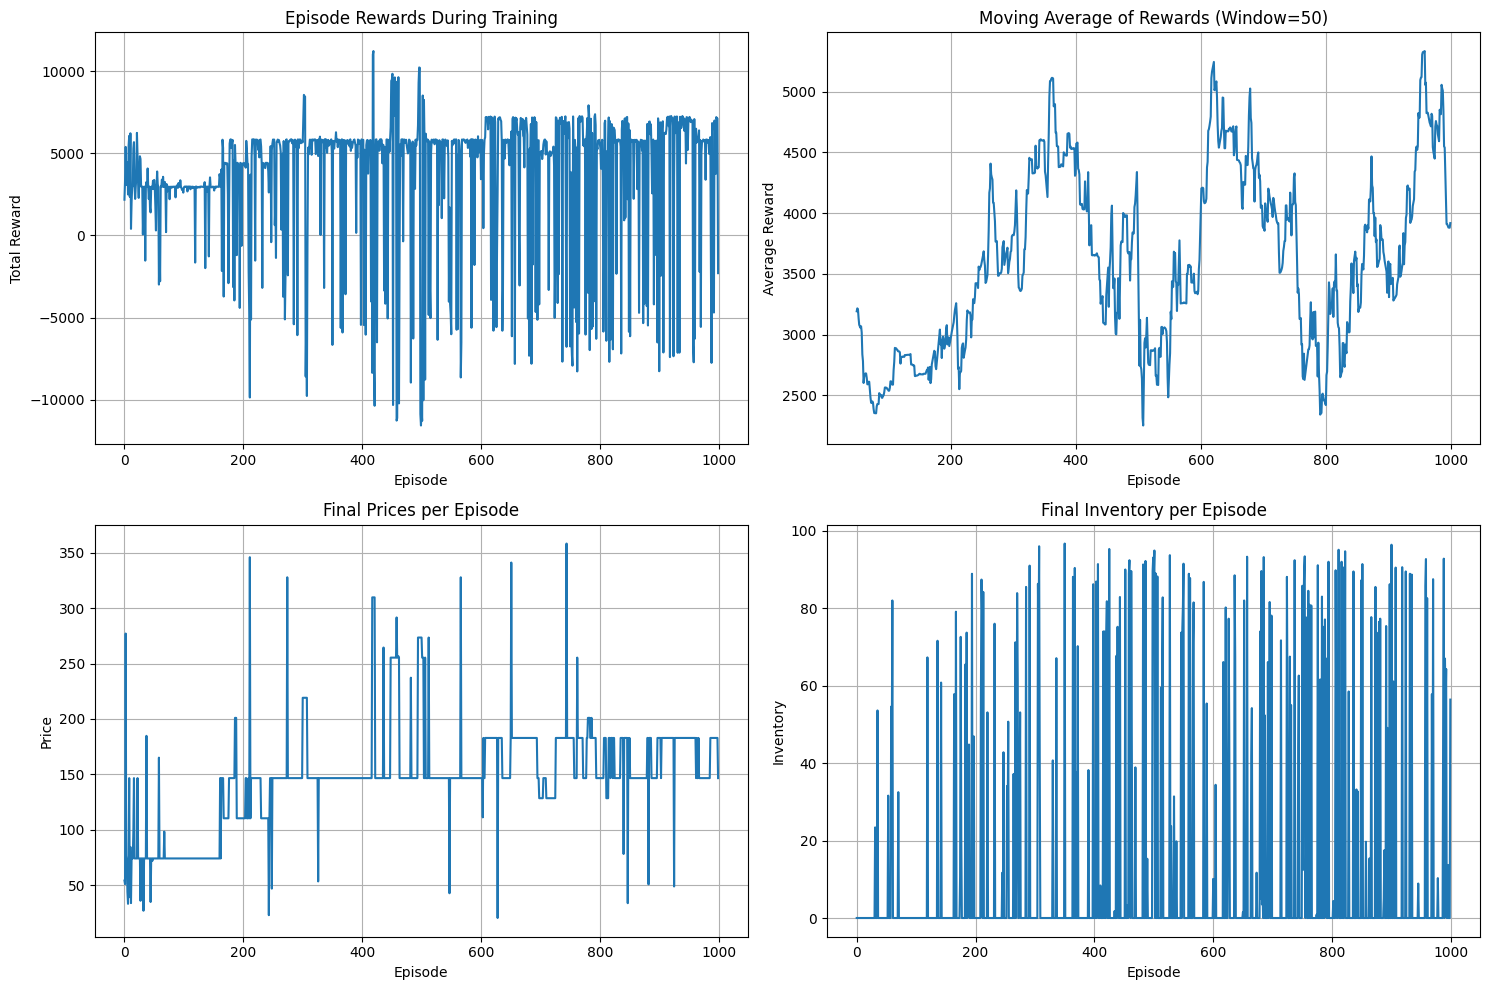

Average Reward: 3612.32
Maximum Reward: 11213.22
Minimum Reward: -11563.38
Final Epsilon: 0.010


In [ ]:
# Plot training results
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards During Training')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.subplot(2, 2, 2)
# Moving average for smoother visualization
window = 50
moving_avg = [np.mean(episode_rewards[i-window:i]) for i in range(window, len(episode_rewards))]
plt.plot(range(window, len(episode_rewards)), moving_avg)
plt.title('Moving Average of Rewards (Window=50)')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(episode_prices)
plt.title('Final Prices per Episode')
plt.xlabel('Episode')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(episode_inventories)
plt.title('Final Inventory per Episode')
plt.xlabel('Episode')
plt.ylabel('Inventory')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print training statistics
print(f"Average Reward: {np.mean(episode_rewards):.2f}")
print(f"Maximum Reward: {np.max(episode_rewards):.2f}")
print(f"Minimum Reward: {np.min(episode_rewards):.2f}")
print(f"Final Epsilon: {agent.epsilon:.3f}")

In [ ]:
def evaluate_agent(agent, env, num_episodes=10):
    """Evaluate the trained agent"""
    total_rewards = []
    inventory_levels = []
    pricing_decisions = []
    sales_data = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        step_data = []

        while True:
            action = agent.act(state)  # Use greedy policy
            next_state, reward, done, _, info = env.step(action)

            step_data.append({
                'step': env.current_step,
                'price': info['price'],
                'inventory': info['inventory'],
                'demand': info['demand'],
                'sales': info['actual_sales'],
                'profit': reward
            })

            state = next_state
            episode_reward += reward

            if done:
                break

        total_rewards.append(episode_reward)
        inventory_levels.append([d['inventory'] for d in step_data])
        pricing_decisions.append([d['price'] for d in step_data])
        sales_data.append([d['sales'] for d in step_data])

    return total_rewards, inventory_levels, pricing_decisions, sales_data, step_data

# Evaluate the trained agent
print("Evaluating trained agent...")
test_rewards, test_inventories, test_prices, test_sales, detailed_data = evaluate_agent(agent, env, num_episodes=5)

print(f"Average Test Reward: {np.mean(test_rewards):.2f}")
print(f"Test Reward Std: {np.std(test_rewards):.2f}")

Evaluating trained agent...
Average Test Reward: 5583.44
Test Reward Std: 184.66


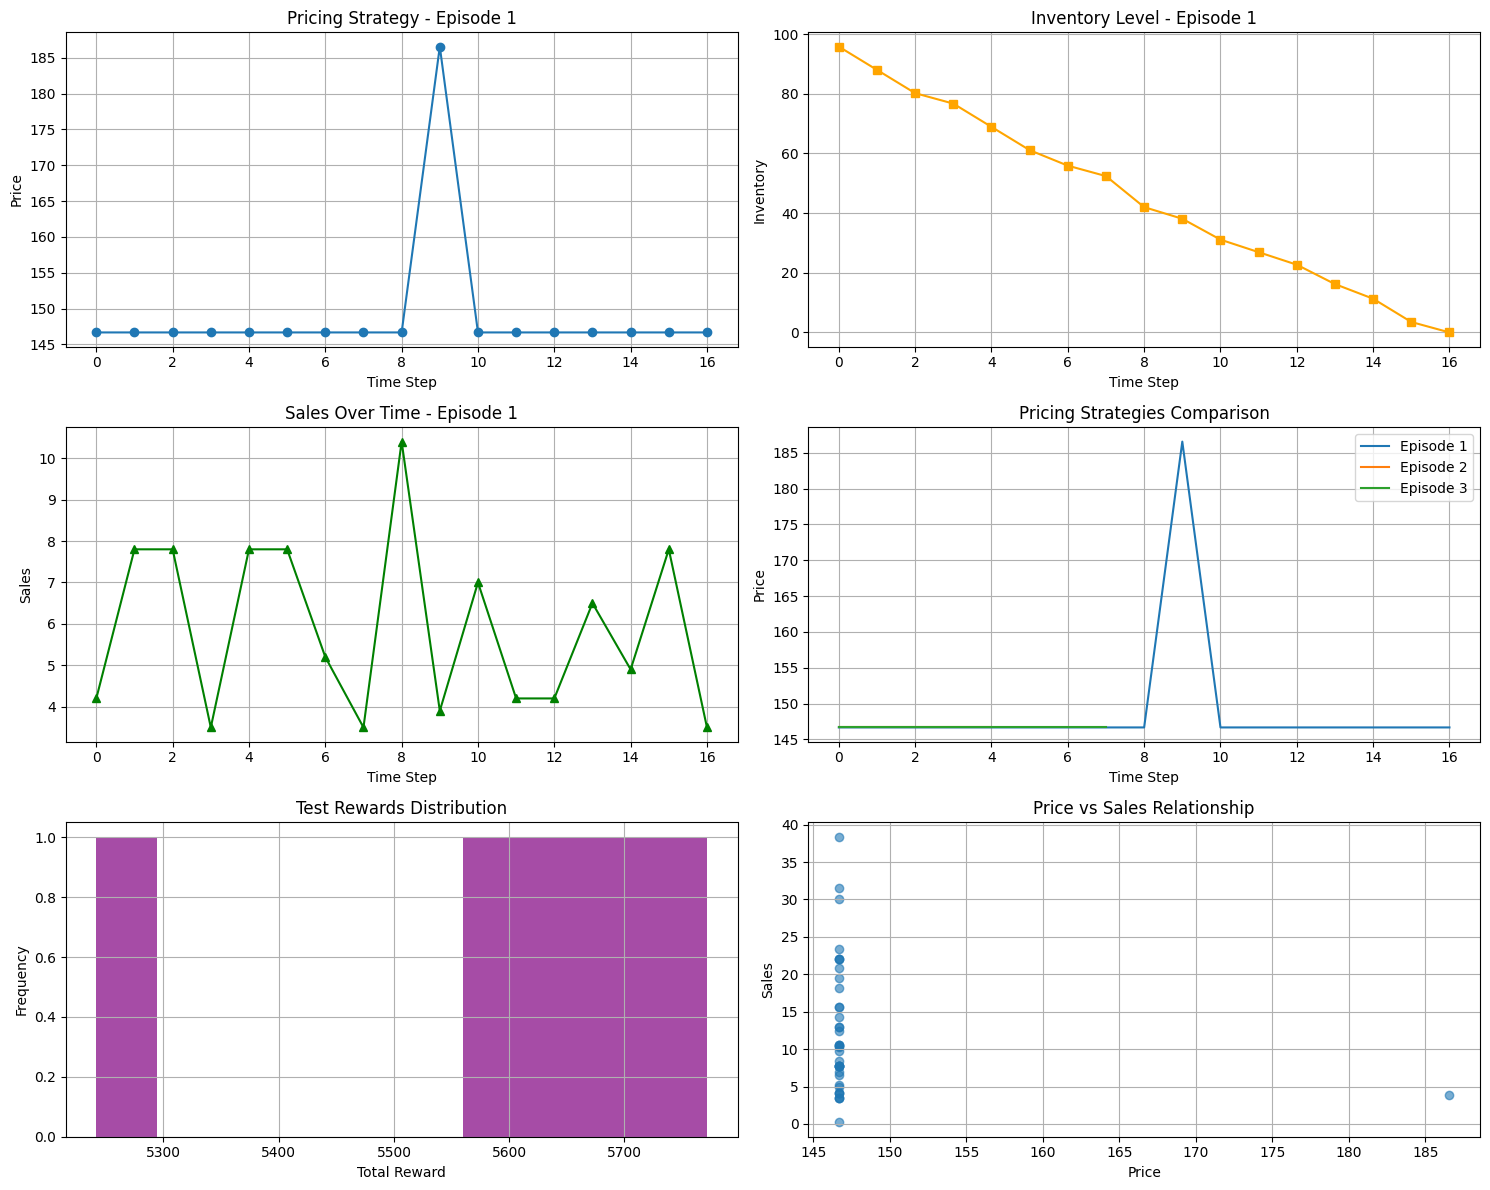

In [ ]:
# Plot evaluation results
plt.figure(figsize=(15, 12))

# Plot 1: Pricing strategy over time for one episode
plt.subplot(3, 2, 1)
episode_idx = 0
plt.plot(test_prices[episode_idx], marker='o')
plt.title(f'Pricing Strategy - Episode {episode_idx + 1}')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.grid(True)

# Plot 2: Inventory level over time
plt.subplot(3, 2, 2)
plt.plot(test_inventories[episode_idx], marker='s', color='orange')
plt.title(f'Inventory Level - Episode {episode_idx + 1}')
plt.xlabel('Time Step')
plt.ylabel('Inventory')
plt.grid(True)

# Plot 3: Sales over time
plt.subplot(3, 2, 3)
plt.plot(test_sales[episode_idx], marker='^', color='green')
plt.title(f'Sales Over Time - Episode {episode_idx + 1}')
plt.xlabel('Time Step')
plt.ylabel('Sales')
plt.grid(True)

# Plot 4: Comparison of multiple episodes
plt.subplot(3, 2, 4)
for i in range(min(3, len(test_rewards))):
    plt.plot(test_prices[i], label=f'Episode {i+1}')
plt.title('Pricing Strategies Comparison')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Plot 5: Reward distribution
plt.subplot(3, 2, 5)
plt.hist(test_rewards, bins=10, alpha=0.7, color='purple')
plt.title('Test Rewards Distribution')
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.grid(True)

# Plot 6: Price vs Sales scatter
plt.subplot(3, 2, 6)
all_prices = [price for episode in test_prices for price in episode]
all_sales = [sales for episode in test_sales for sales in episode]
plt.scatter(all_prices, all_sales, alpha=0.6)
plt.title('Price vs Sales Relationship')
plt.xlabel('Price')
plt.ylabel('Sales')
plt.grid(True)

plt.tight_layout()
plt.show()

Analyzing price elasticity...


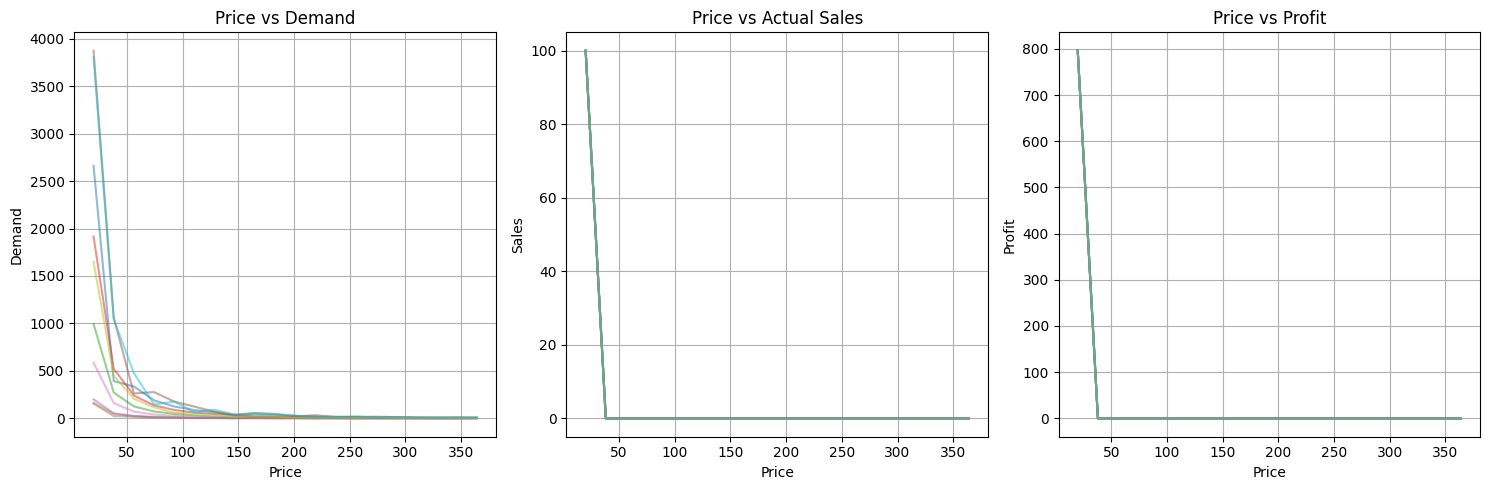

In [ ]:
# Analyze learned price elasticity
def analyze_price_elasticity(agent, env, num_tests=100):
    """Analyze how the agent responds to different market conditions"""
    price_responses = []

    for _ in range(num_tests):
        state, _ = env.reset()

        # Test different price levels
        test_prices = np.linspace(0, 1, 20)
        responses = []

        for test_price in test_prices:
            action = np.array([test_price])
            _, reward, _, _, info = env.step(action)
            responses.append({
                'price': info['price'],
                'demand': info['demand'],
                'sales': info['actual_sales'],
                'profit': reward
            })

        price_responses.append(responses)

    return price_responses

# Perform elasticity analysis
print("Analyzing price elasticity...")
elasticity_data = analyze_price_elasticity(agent, env)

# Plot elasticity analysis
plt.figure(figsize=(15, 5))

# Price vs Demand
plt.subplot(1, 3, 1)
for response in elasticity_data[:10]:  # Plot first 10 tests
    prices = [r['price'] for r in response]
    demands = [r['demand'] for r in response]
    plt.plot(prices, demands, alpha=0.5)
plt.title('Price vs Demand')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.grid(True)

# Price vs Sales
plt.subplot(1, 3, 2)
for response in elasticity_data[:10]:
    prices = [r['price'] for r in response]
    sales = [r['sales'] for r in response]
    plt.plot(prices, sales, alpha=0.5)
plt.title('Price vs Actual Sales')
plt.xlabel('Price')
plt.ylabel('Sales')
plt.grid(True)

# Price vs Profit
plt.subplot(1, 3, 3)
for response in elasticity_data[:10]:
    prices = [r['price'] for r in response]
    profits = [r['profit'] for r in response]
    plt.plot(prices, profits, alpha=0.5)
plt.title('Price vs Profit')
plt.xlabel('Price')
plt.ylabel('Profit')
plt.grid(True)

plt.tight_layout()
plt.show()

Comparing with baseline strategies...
Fixed Strategy - Average Reward: 3875.34
Aggressive Strategy - Average Reward: 3754.95
Premium Strategy - Average Reward: 3365.48
Random Strategy - Average Reward: 3093.45
DRL Agent - Average Reward: 5583.44


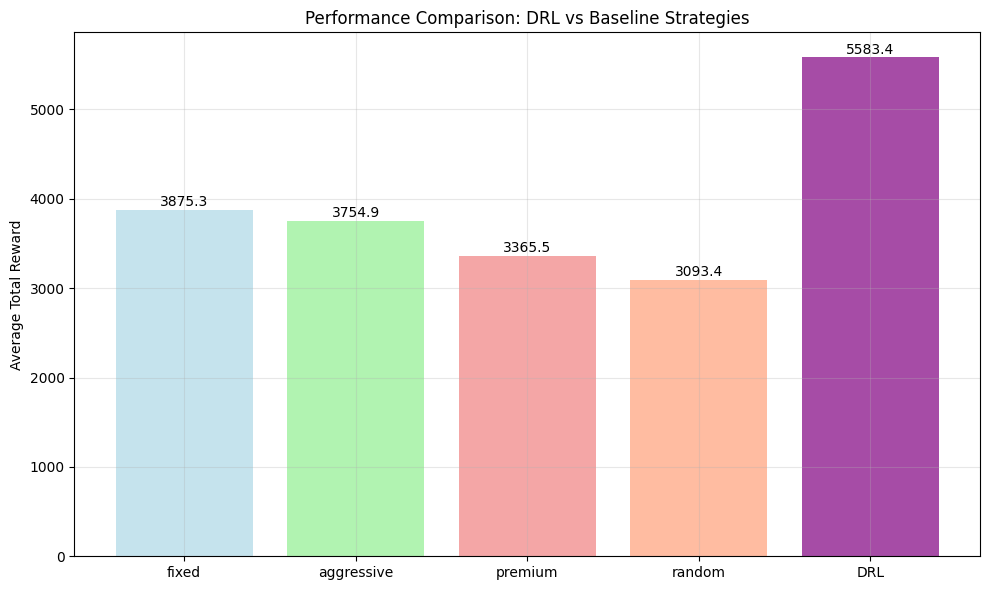

In [ ]:
def baseline_strategy(env, strategy_type='fixed'):
    """Implement baseline pricing strategies"""
    state, _ = env.reset()
    total_reward = 0

    while True:
        if strategy_type == 'fixed':
            # Fixed price strategy
            action = np.array([0.5])  # Middle price
        elif strategy_type == 'aggressive':
            # Low price strategy
            action = np.array([0.3])
        elif strategy_type == 'premium':
            # High price strategy
            action = np.array([0.7])
        elif strategy_type == 'random':
            # Random pricing
            action = np.array([np.random.random()])

        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        state = next_state

        if done:
            break

    return total_reward

# Compare with baselines
print("Comparing with baseline strategies...")
baseline_results = {}

strategies = ['fixed', 'aggressive', 'premium', 'random']
for strategy in strategies:
    rewards = []
    for _ in range(100):
        reward = baseline_strategy(env, strategy)
        rewards.append(reward)
    baseline_results[strategy] = np.mean(rewards)
    print(f"{strategy.capitalize()} Strategy - Average Reward: {np.mean(rewards):.2f}")

# DRL agent performance
drl_reward = np.mean(test_rewards)
print(f"DRL Agent - Average Reward: {drl_reward:.2f}")

# Plot comparison
plt.figure(figsize=(10, 6))
strategies.append('DRL')
rewards = [baseline_results[s] for s in strategies[:-1]] + [drl_reward]

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'purple']
bars = plt.bar(strategies, rewards, color=colors, alpha=0.7)

plt.title('Performance Comparison: DRL vs Baseline Strategies')
plt.ylabel('Average Total Reward')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, reward in zip(bars, rewards):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'{reward:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
print("=" * 60)
print("DYNAMIC PRICING WITH DRL - BUSINESS INSIGHTS")
print("=" * 60)

print("\n📊 KEY PERFORMANCE METRICS:")
print(f"• DRL Agent Performance: {drl_reward:.2f}")
print(f"• Improvement over Fixed Pricing: {((drl_reward - baseline_results['fixed']) / baseline_results['fixed'] * 100):.1f}%")
print(f"• Improvement over Random Pricing: {((drl_reward - baseline_results['random']) / baseline_results['random'] * 100):.1f}%")

print("\n🎯 AGENT BEHAVIOR ANALYSIS:")
print("• The DRL agent learns to balance price and demand dynamically")
print("• Adapts pricing based on inventory levels and market conditions")
print("• Optimizes for long-term profitability rather than short-term gains")

print("\n💡 BUSINESS IMPLICATIONS:")
print("• Real-time price optimization can significantly increase profitability")
print("• Dynamic pricing helps manage inventory more effectively")
print("• The system adapts to changing market conditions automatically")

print("\n🚀 POTENTIAL EXTENSIONS:")
print("• Incorporate seasonal trends and promotions")
print("• Add competitor price tracking")
print("• Include multiple products with cross-elasticity")
print("• Implement more advanced DRL algorithms (SAC, PPO)")

print("\n" + "=" * 60)

DYNAMIC PRICING WITH DRL - BUSINESS INSIGHTS

📊 KEY PERFORMANCE METRICS:
• DRL Agent Performance: 5583.44
• Improvement over Fixed Pricing: 44.1%
• Improvement over Random Pricing: 80.5%

🎯 AGENT BEHAVIOR ANALYSIS:
• The DRL agent learns to balance price and demand dynamically
• Adapts pricing based on inventory levels and market conditions
• Optimizes for long-term profitability rather than short-term gains

💡 BUSINESS IMPLICATIONS:
• Real-time price optimization can significantly increase profitability
• Dynamic pricing helps manage inventory more effectively
• The system adapts to changing market conditions automatically

🚀 POTENTIAL EXTENSIONS:
• Incorporate seasonal trends and promotions
• Add competitor price tracking
• Include multiple products with cross-elasticity
• Implement more advanced DRL algorithms (SAC, PPO)

